# Rivest-Shamir-Adleman

Please, install the [Pycryptodome](https://github.com/Legrandin/pycryptodome) packages before running the code.

In [1]:
# import own functions and class
from rsa import *
# import math function gcd
from math import gcd
# import pyplot
import matplotlib.pyplot as plt
# import AES functions
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad, unpad
from Crypto.Cipher import AES

## Introduction

The **RSA algorithm** is an asymmetric algorithm widely used in cryptography to create a secure communication channel. It is typically combined with a symmetric algorithm to leverage the strengths of both. This document will focus on the implementation of the RSA algorithm, which involves elements of Number Theory and other well-known algorithms (such as **Extended Euclidean**, **Square and Multiply**, and **Miller-Rabin**) to realize encryption and decryption functions. Furthermore, this document will demonstrate a typical application of this by realizing a hybrid system using **AES** as the symmetric algorithm. The implementation of RSA requires computation with large integer numbers. Therefore, towards the end, this document will focus on a common problem in RSA implementation: the **occurrence of large prime numbers**.

## RSA algorithm

The *RSA algorithm*, established in **1977**, is a widely used **asymmetric algorithm** for secure communication. It operates on a pair of keys: a public key (**𝑘pub**) for encryption and a private key (**𝑘priv**) for decryption. The key generation process involves five steps: 
1. Choose two **prime** numbers **(𝑝, 𝑞)**
2. Computing **𝑛 = 𝑝 ⋅ 𝑞**
3. Computing **𝑚 = (𝑝 − 1)(𝑞 − 1)**
4. Drawing **𝑒** from $ℤ_𝑛$ such that **gcd(𝑒, 𝑚) = 1**
5. Computing **𝑑** such that **𝑑 ⋅ 𝑒 ≡ 1 mod m**
   
The plaintext and ciphertext in RSA are modeled as integers **(𝑥, 𝑦) in $ℤ_𝑛$**, where **𝑦 = $x^e$ mod n** for Encryption and **x = $y^d$ mod n** for Decryption. The implementation of RSA involves the use of the **Extended Euclidean Algorithm**, the **Square and Multiply method**, and the **Miller Rabin test**[[1]](#[1]).

The security of RSA is based on the *difficulty of factoring the product of two **large** prime **numbers***, which is a problem known to be hard in the field of number theory[[1]](#[1]).

<img src="Images/rsa.png" width="540" height="340" style="margin:auto"/>

### testing

* **Extended Euclidean Algorithm (EEA)**

It is an *extension of the Euclidean algorithm*, which is used to compute the **greatest common divisor (gcd)** of two integers a and m, and also to compute the *coefficients of **Bézout’s identity***. These coefficients are integers (say s and t) such that: $$a\cdot s+m\cdot t=gcd(a,m)$$The EEA is useful when a and m are coprime ($gcd(a,m)=1$), in this case *s* is the modular multiplicative inverse of *a* modulo *m* ($s\equiv a^{-1}\space mod\space m$) [[1]](#[1]).

Thanks to the modular multiplicative inverse, *EEA is an essential step in the derivation of key-pairs* in the RSA public-key encryption method. The standard Euclidean algorithm uses Euclidean divisions, keeping only remainders, instead the extended version also uses quotients. The process stops at a zero remainder, with the last non-zero remainder as the gcd. The Extended Euclidean Algorithm (EEA) adds two sequences to this and stops when it finds the gcd.[[2]](#[2])

In [2]:
# num of test
N_test = 10_000
# max range
n_range = 2**256

# test
for _ in range(N_test):
    # random
    a = randint(0,n_range) 
    m = randint(0,n_range)
    # EEA
    r, s, t = EEA(a, m)
    # check if the GCD is correct
    r_math = gcd(a,m)
    assert r == r_math, f"Expected {r_math}, but got {r}"
    # check if the Bézout's identity holds
    assert a*s + m*t == r, f"Expected {a*s + m*t}, but got {r}"

print('Test PASS.')

Test PASS.


* **Square and Multiply**

When you deal with **very high numbers** (e.g., x, e ∈ $ℤ_{2^{2048}}$), it is not trivial to compute $x^e$ as it may require an **unworkable amount of time**. To solve this problem many **algorithms for fast and efficient exponentiation** have been studied, for example Square-and-Multiply also known as the binary exponentiation algorithm. It is a method used to compute **powers of a number quickly**. *It’s based on the binary representation of the exponent*[[1]](#[1]):
1. **Square**: In each step, the current number is squared, regardless of the exponent’s bits.
2. **Multiply**: Only when the corresponding bit in the exponent’s binary representation is 1, the result of the squaring is multiplied by the base number.

In the context of modular arithmetic, each squaring and multiplication operation is followed by taking the **modulus**, *keeping the numbers small and manageable* throughout the computation. This means that we compute: $$x^e\space mod\space m$$
This method is efficient because it performs at most 2n operations for an n-bit exponent, which is significantly less than the naive method of multiplying the base number by itself for the exponent ent times. Its simplicity and efficiency make it a popular choice in cryptographic computations where large numbers are common[[3]](#[3]).

In [3]:
# num of test
N_test = 10_000
# max range
n_range = 2**128


for _ in range(N_test):
    # random
    x = randint(0,n_range) 
    e = randint(1,n_range)
    n = randint(1,n_range)
    # sam
    result = SaM(x, e, n)
    # check if result is correct
    expected = pow(x, e, n)
    assert result == expected, \
    f"For x={x}, e={e}, n={n}: Expected {expected}, but got {result}"

print('Test PASS.')

Test PASS.


As shown below it's possible to see how basic operation instead of S&M algoh take much more times for computation.

In [4]:
# num of test
N_test = 1000
# max range
n_range = 2**16

# execution time for SaM
et_sam = execution_time(True, N_test, n_range)
print(f'Execution time for SaM: {et_sam:.3f}s')
# execution time for (x**e)\n
et_basic = execution_time(False, N_test, n_range)
print(f'Execution time for basic operation: {et_basic:.3f}s')

Execution time for SaM: 0.020s
Execution time for basic operation: 33.046s


* **Miller-Rabin Primality Test**

Test to determines whether a given number is **likely to be prime or surely composite**[[1]](#[1]). *The chance of a composite number passing the test is at most 1/4 per iteration*. Therefore, after several iterations, the probability that a composite number is mistakenly considered prime can be made arbitrarily small[[4]](#[4]). But, increasing the number of iterations will also increase the computational time so, the goal is to **balance** the need for **precision with the computational resources** available.

*Note: **N** as number of iterations, for entire relation except for large number task, is set to one hundred due to balance between time for compution and a better security reached out after some trials.* 

In [5]:
# N test for MR
N = 100

for p in range(2, 301):
    # prime or not
    expected = is_prime(p)
    # probably prime or surely not
    result = MR(p, N)
    if expected != result:
        # surely composite assumption wrong
        assert not(expected == True and result == False),\
            f'{p} is prime! Expected {expected} but got {result}'
        # likely prime wrong
        if expected == False and result == True:
            print(f'{p} prime is statistically wrong.')

print('Test PASS.')

Test PASS.


* **RSA class**

Implementation of a RSA encryption and decryption method. *If you create an instance of it specifying only the length, you have set up RSA for encryption. Otherwise, if you pass the public key, you have set up RSA for decryption.*

Note: It’s important to set a length that is at least as large as the plaintext integer space, or in other words, **x, y$\in ℤ_n$**, to ensure the correct functioning of RSA.

In [6]:
#instances
bob = RSA(length=128)
alice = RSA(n=bob.n, e=bob.e)
# encryption and decryption
ciphertext = alice.encrypt(b'Hello World!')
print('Encrypted text: ', ciphertext)
plaintext = bob.decrypt(ciphertext)
print('Decrypted text: ',plaintext)

Encrypted text:  b'(\xbblC\xf9\xaahI\xee\xde\xd0kW\x99p]'
Decrypted text:  b'Hello World!'


## RSA and AES

The ***Advanced Encryption Standard*** (AES) is a symmetric-key encryption specification established by the National Institute of Standards and Technology (**NIST**). Each cipher operates on a 128-bit block size with variety of operating procedure, but they differ in key sizes[[5]](#[5]). It’s much faster and more efficient than RSA for encrypting large amounts of data, but it requires that the key be kept secret and securely shared between the sender and receiver. So, typically solution is hybrid encryption system where RSA and AES are used together to get the best of both worlds[[1]](#[1]).

<img src="Images/rsa-aes.png" width="540" height="340" style="margin:auto"/>

In [7]:
# load plaintext
with open(file='lorem_ipsum.txt', mode='r') as f:
    x = f.read()
# pad data for aes
x_padded = pad(x.encode(), AES.block_size)

In [8]:
# plaintext
print(x[:892],'\n\n[...]\n\n', x[22626:])

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Tempus iaculis urna id volutpat. Consequat mauris nunc congue nisi. Gravida quis blandit turpis cursus in hac habitasse. Cras pulvinar mattis nunc sed blandit. Morbi non arcu risus quis varius quam quisque. Tristique magna sit amet purus gravida quis blandit. Consequat ac felis donec et odio pellentesque diam volutpat. In egestas erat imperdiet sed euismod nisi. Ante in nibh mauris cursus mattis molestie a iaculis. Nec tincidunt praesent semper feugiat nibh. Tortor id aliquet lectus proin nibh nisl condimentum. Neque egestas congue quisque egestas. Aliquam id diam maecenas ultricies. Vitae purus faucibus ornare suspendisse sed. Orci phasellus egestas tellus rutrum tellus pellentesque eu tincidunt tortor. Mi tempus imperdiet nulla malesuada pellentesque elit. 

[...]

 Pretium fusce id velit ut tortor pretium viverra suspendisse potenti. Sed euismod nisi porta lore

In [9]:
# Alice
kAES = b'RSA+AES crypto____RSA+AES crypto'
Bob_RSA = RSA(length=1024)
Alice_RSA = RSA(n=Bob_RSA.n, e=Bob_RSA.e)
EncRSA = Alice_RSA.encrypt(kAES)

Alice_AES = AES.new(kAES, AES.MODE_ECB)
y = Alice_AES.encrypt(x_padded)

In [10]:
# ciphertext
print(y[:892],'\n\n[...]\n\n', y[22626:])

b"\xfd\xfe?\xdaX\x04t\x1e\xec\xa4\xd66Jw\xf0\xab\x8a\xd8\xac:\xc9\x87\\e\x9a\xdc\xd1H\x02\xef\x83\xc7\x15S\xc9,\x9f\xbd\xc8\r\xe8M_\x1b\xc7'6\x9f\xb1\xe0\x96\xff\x0b\xfb\xca\x7fQ|\xd5\xc9q\x82\x14\x86xz\x06#\x81\xbf\t;\xf8\xd4\x9f\x19z\xba\xfc9\xcb\xcd\xbe\xac\xb2e\x9a\x96\xe4\x91\x9d\xb4k\xf3\xba\x04\xc8\x19{?\xc3\xf6\xdf\x19K\x9e\xdb\x9b>|\xe5GsM\xbe}\xd0\xe3\x05\x03\xe9\x0f\x1a\x04\x82XCM\r\xb3\x88\x06J\xe6\x8f\xf0\xa2\x93\x92\x92\x9be\x93\xfcF?\x11Y\x0f\xab\x84\x9fD\x99\xba1\xba\xec\x89\x9eQ\xbf\x95\xe25\xc6(\x94T\x931Z\xc9\xbfI\xc0%g\x8b\xce\x99\xc6J\xa0\x15\xb2\xcb\x18\xdc\xcf\xe7\xab\xe3\x95\xc5\xa6\xe1\xfb\xf1\x7f\xf9B\xa6\xf7\x81m\xce\xba2\x86W\xf4\xe9\x86\x8do\xe0.\xd6t\xc0\x94\xb6\xfa`\xa3Yh\x86\xdc7\xe0\xd3\xb9\xa2)\xb4\x9f\xd1\xe8\xebT\x84;8\xeb\xf3(9}\xbe\x1c\x88\x99$\xa6\x1c\xb5xj\xa4IL0\x9a^3\xe3\x86H\xdf*\n\xc6Y\x9d\xa1L\xf8\xaf\xccx\xb5\x80>`Yl\xbfg\xdf\x0e\x9dr\xcb\xe7Z\xc0\x86\xe5\xf6/\xe8W!\xf4\xf8\xa2\x11>w^\xed[\xc0\x17\x05\xe9>n|]X\x994\xdc^\x96\xa5\x81k?4\xf2\x

In [11]:
# Bob
kAES_bob = Bob_RSA.decrypt(EncRSA)
Bob_AES = AES.new(kAES_bob, AES.MODE_ECB)
x_padded_dec = Bob_AES.decrypt(y)

In [12]:
# decrypted plaintext
x_dec = unpad(x_padded_dec, AES.block_size)
print(x_dec.decode()[:892],'\n\n[...]\n\n', x_dec.decode()[22626:])

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Tempus iaculis urna id volutpat. Consequat mauris nunc congue nisi. Gravida quis blandit turpis cursus in hac habitasse. Cras pulvinar mattis nunc sed blandit. Morbi non arcu risus quis varius quam quisque. Tristique magna sit amet purus gravida quis blandit. Consequat ac felis donec et odio pellentesque diam volutpat. In egestas erat imperdiet sed euismod nisi. Ante in nibh mauris cursus mattis molestie a iaculis. Nec tincidunt praesent semper feugiat nibh. Tortor id aliquet lectus proin nibh nisl condimentum. Neque egestas congue quisque egestas. Aliquam id diam maecenas ultricies. Vitae purus faucibus ornare suspendisse sed. Orci phasellus egestas tellus rutrum tellus pellentesque eu tincidunt tortor. Mi tempus imperdiet nulla malesuada pellentesque elit. 

[...]

 Pretium fusce id velit ut tortor pretium viverra suspendisse potenti. Sed euismod nisi porta lore

## Finding Large Primes

RSA requires to randomly draw two large prime numbers 𝑝,𝑞 ~ $2^{𝐿/2}$ (where 𝐿 is the key length). However, as numbers get larger, the gaps between primes tend to increase, making **large primes less frequent**. Moreover, predicting the exact location of large primes becomes increasingly difficult as numbers grow larger. Knowing that prime numbers become less dense as their values increase, **is there a reasonable chance that a large random number is prime?** A possible solution is to determine the probability for a large random number to be prime[[1]](#[1]):
$$ Prob( p\space prime\space |\space p\sim U\{ 2^{L/2}+1,\space 2^{L/2}+3,...,\space 2^{L/2+1}-1\} )$$

In [13]:
# number of trials for sim
N = [10,100,1000,5000]

for n in N:    
    # compute probability
    prob = prime_probability(8,n,100)
    err = abs(0.625-prob)
    print(f'{n:7} trials - Prob(𝑝 prime|𝑝~U) = {prob:.4f}, with Err = {err:.4f}')

# expected probability with L = 8 ---> 0.625

     10 trials - Prob(𝑝 prime|𝑝~U) = 0.5000, with Err = 0.1250
    100 trials - Prob(𝑝 prime|𝑝~U) = 0.7100, with Err = 0.0850
   1000 trials - Prob(𝑝 prime|𝑝~U) = 0.6590, with Err = 0.0340
   5000 trials - Prob(𝑝 prime|𝑝~U) = 0.6370, with Err = 0.0120


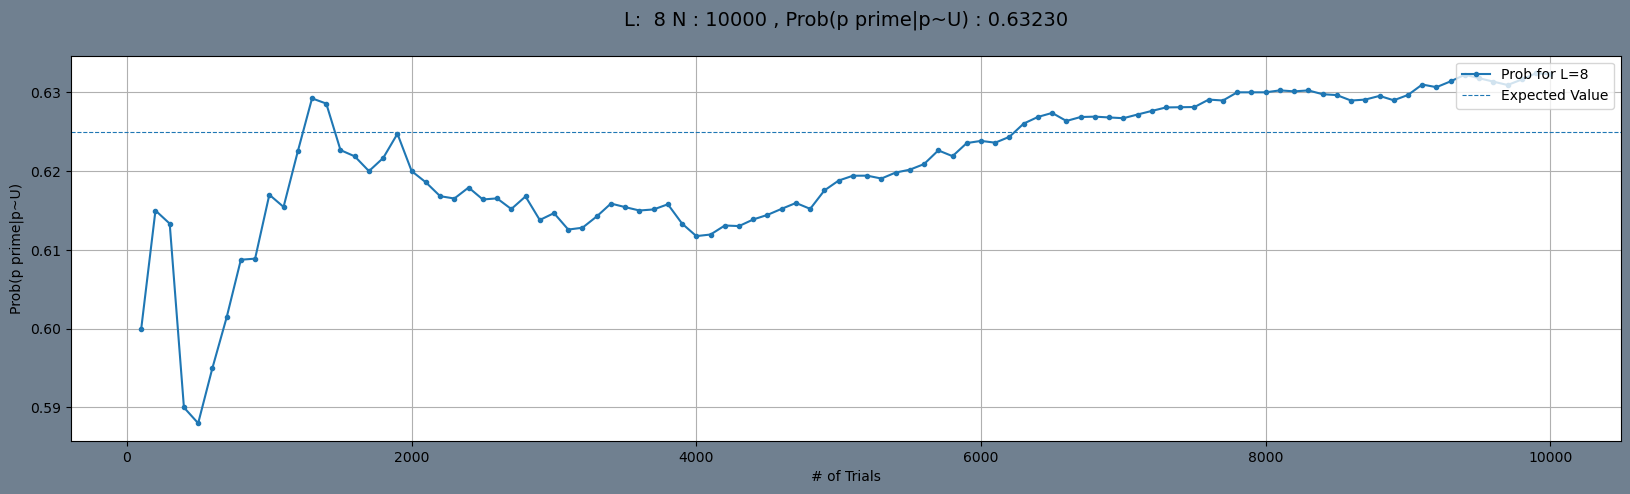

In [14]:
# init
N = 10_000
n_steps = 100
L = 8
# number of trials for MR in PP
n_MR = 20

# plot
plt.figure(figsize=(20,5)).set_facecolor('slategrey')
plt.xlabel('# of Trials')
plt.ylabel('Prob(p prime|p~U)')
e = prime_probability(L,N,n_MR,n_steps)
N_trials = [i for i in range(n_steps,N+1,n_steps)]
# plot
plt.plot(N_trials,e,marker = '.',label=f'Prob for L={L}')
plt.axhline(y=0.625,linestyle = '--',linewidth=0.8, label='Expected Value')
str = 'L: {:2} N : {:5} , Prob(p prime|p~U) : {:.5f}\n'.format(L,N,e[-1])

plt.title(str,fontsize=14)
plt.legend(loc="upper right")  
plt.grid()    
plt.show()

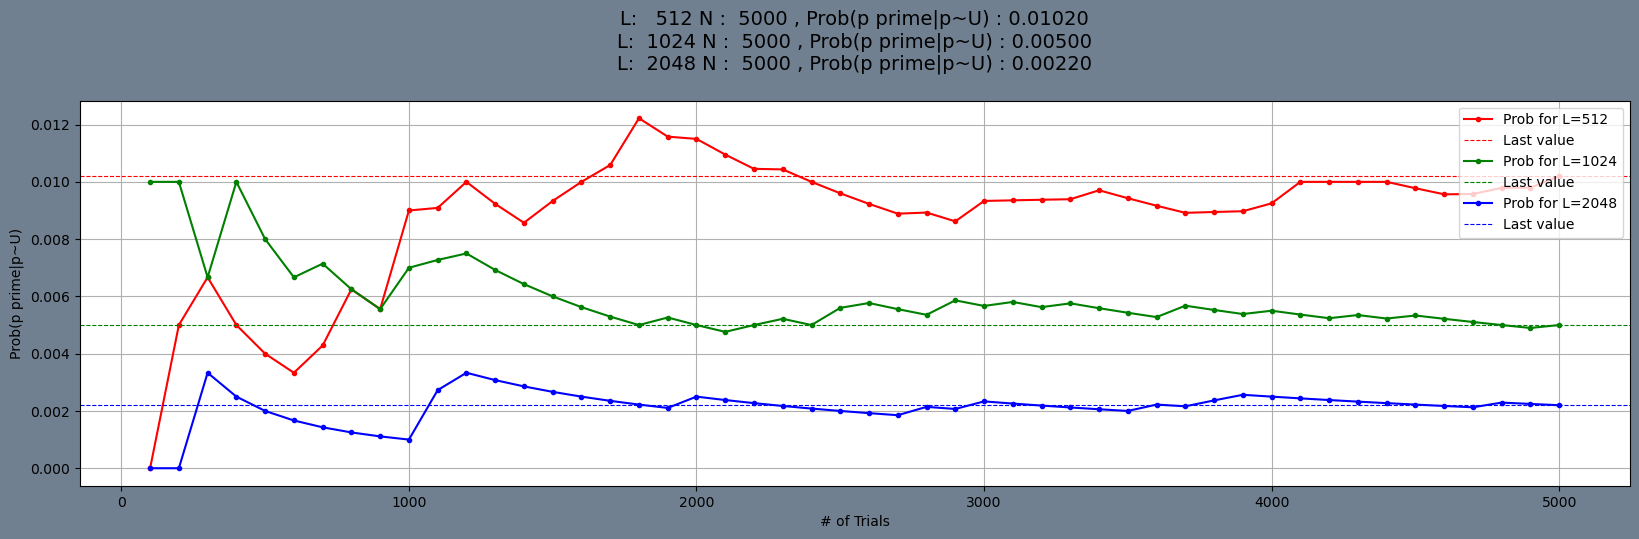

In [15]:
N = 5000
n_steps = 100
L = [512,1024,2048]
colors = ['red', 'green', 'blue']
# number of trials for MR in PP
n_MR = 20
str = ''

plt.figure(figsize=(20,5)).set_facecolor('slategrey')
plt.xlabel('# of Trials')
plt.ylabel('Prob(p prime|p~U)')

for j,l in enumerate(L):
    e = prime_probability(l,N,n_MR,n_steps)
    N_trials = [i for i in range(n_steps,N+1,n_steps)]
    # plot
    plt.plot(N_trials,e,color=colors[j],marker = '.',label=f'Prob for L={l}')
    plt.axhline(y=e[-1],color=colors[j],linestyle = '--',linewidth=0.8, label='Last value')
    str += 'L: {:5} N : {:5} , Prob(p prime|p~U) : {:.5f}\n'.format(l,N,e[-1])

plt.title(str,fontsize=14)
plt.legend(loc="upper right")  
plt.grid()    
plt.show()

The plot above shows, as expected, that increasing the length L lowers the probability of finding a prime number. Obviously, this is an approximation where the number of trials for the Miller-Rabin test to check primality and the maximum number of trials for simulating the estimation of probability are small to avoid high computation time. To reach a better estimation of probability without taking into account computation time, it’s possible to increase the accuracy of the Miller-Rabin test  and also the maximum number of trials to see longer curves in the plot, verifying where each curve trends. Another solution is to set a value for error tolerance and use it as a stop criterion: when the error, computed as the difference between the last 3, 4, or 5 points, is smaller than the previously set error tolerance, it’s possible to take the last value of estimated probability as the probability of finding a prime number if uniformly drawn in that set related to the length L.

## Conclusion

The implementation of RSA and AES algorithms underscores the **critical balance between security and computational efficiency** in cryptographic systems. Utilizing a hybrid encryption system that combines the RSA algorithm’s secure key exchange with AES’s fast data encryption offers a powerful solution for secure communications. However, challenges persist in the realm of Prime Numbers: the exploration of large prime numbers for RSA highlights the **complexities of number theory in cryptography**, emphasizing the importance of rigorous primality testing.

This study not only solidifies the necessity for strong encryption methods but also illuminates the ongoing challenge of adapting to the dynamic landscape of cybersecurity.

## Reference

<span id='[1]' > [1] <a href = "RSA.pdf"> Rivest-Shamir-Adleman </a>
<br><span id='[2]' > [2] [Extended Euclidean algorithm](https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm)</span>
<br><span id='[3]' > [3] [Square & Multiply algorithm](https://en.wikipedia.org/wiki/Exponentiation_by_squaring) with [example](https://math.stackexchange.com/questions/1472480/learning-square-and-multiply-algorithm)</span>
<br><span id='[4]' > [4] [Miller-Rabin primality test](https://en.wikipedia.org/wiki/Miller%E2%80%93Rabin_primality_test) </span>
<br><span id='[5]' > [5] [Advanced Encryption Standard](https://it.wikipedia.org/wiki/Advanced_Encryption_Standard) </span>